This notebook addresses the question, "Can we represent a molecule as a graph via a 1D column vector or a 2D matrix of fixed length, with maximum number of atoms n_rows?" Then, can we use this representation to learn neural fingerprints? E.g., can we make an aromatic ring detector? 

Scheme:
feature_matrix = X
for each ligand:
    choose a central atom. this can be the atom (node) that minimizes distance to furthest heavy atom in graph.
    set first row of X to be this central atom
    set next four rows to be the atoms bonded to that centrl atom
        set zeros for rows where row ind > n_bonds of atom
    for each of those atoms:
        repeat. find their neighbors. add to matrix.

algorithm: breadth-first search:
1. create networkx graph based on molecule
2. find "central" atom (different strategies)
3. define atom matrix of size (1+4+4*3^(L-1)) x (n_features_per_atom)
4. start atom queue q
5. central_atom.layer = 0; central_atom.row_idx = 0;
6. q.enqueue(central_atom)
7. define adjacency matrix of size (1+4+4*3^(L-1)) x 4

def get_row_idx(curr_layer, prev_row_idx, curr_neighbor_idx):
    if curr_layer == 0:
        return(0)
    if curr_layer == 1:
        row_idx = 1 + curr_neighbor_idx
    if layer == 2:
        last_max = 5
        row_idx = last_max + (3*(prev_row_idx-last_max)) + curr_neighbor_idx
    if layer > 2:
        last_max = 5 + 4*3^(curr_layer-2) 
        row_idx = last_max + 3*(prev_row_idx-last_max) + curr_neighbor_idx
    return(row_idx)
    

while q.is_not_empty():
    a = q.dequeue()
    a.visited = True
    for n_idx, n in enumerate(a.neighbors()):
        if not n.visited:
            row_idx = c
            n.layer = a.layer + 1
            row_idx = get_row_idx(n.layer, a.row_idx, n_idx)
            n.row_idx = row_idx
            adj_matrix[a.row_idx][n_idx] = n.row_idx
            atom_matrix[row_idx][elem_to_idx[n.elem]] = 1

input_matrix = tf.concat([atom_matrix, atom_matrix[adj_matrix[:,0]], atom_matrix[adj_matrix[:,1]], atom_matrix[adj_matrix[:,2]], atom_matrix[adj_matrix[:,3]]

neural net:
h1 = relu([tf.zeros([n_features_per_atom, 4]) * input_matrix + bias))
h1_conc = tf.concat([h1, h1[adj_matrix[:,0], ..., h1[adj_matrix[:,3])

repeat h1 to get h2


dihedral predictor pseudocode:

get bonds for molecule
create networkx graph out of molecule (use atom indices)

for each edge:
   for neighbor_i in atom_i.neighbors():
       if neighbor_i == atom_j: continue
       for neighbor_j in atom_j.neighbors():
           if neighbor_j == atom_i: continue
           dihedrals.append((neighbor_i, atom_i, neighbor_j, atom_j))
           check to make sure (atom_j, neighbor_j, atom_i, neighbor_i)) not already in list

for dihedral in dihedrals:
    angle =  rdMolTransforms.GetDihedralDeg(c, 0,1,2,3)


In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random

In [3]:
def get_torsions_angles(mol, n_bonds=200, n_atoms=200):
    c = mol.GetConformer(0)

    torsions = []
    torsion_tuples = []
    
    torsion_matrix = np.zeros((n_bonds,3))
    torsion_indices = np.zeros((n_bonds,n_atoms,12)).astype(np.uint8)
    
    bond_adjacency = np.zeros((n_bonds,n_bonds)).astype(np.uint8)
    idx = 0
    for bond in mol.GetBonds():
        if bond.IsInRing(): 
            continue

        def calc_torsions(atom_i, atom_j, bond_idx):        
            exist_dihed = False
            for neighbor_j in atom_j.GetNeighbors():
                if neighbor_j.GetIdx() == atom_i.GetIdx():
                    continue

                dihed_idx = 0
                for neighbor_i in atom_i.GetNeighbors():
                    if neighbor_i.GetIdx() == atom_j.GetIdx():
                        continue

                    exist_dihed=True
                    torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                    torsion_matrix[bond_idx][dihed_idx] = np.cos(rdMolTransforms.GetDihedralRad(c, *torsion_tuple))
                    torsion_indices[bond_idx][torsion_tuple[0]][dihed_idx*4] = 1
                    torsion_indices[bond_idx][torsion_tuple[1]][dihed_idx*4+1] = 1
                    torsion_indices[bond_idx][torsion_tuple[2]][dihed_idx*4+2] = 1
                    torsion_indices[bond_idx][torsion_tuple[3]][dihed_idx*4+3] = 1
                    dihed_idx += 1
                break
        
        calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx)
        idx += 1
        calc_torsions(bond.GetEndAtom(), bond.GetBeginAtom(), idx)
        idx += 1
    
        atom_i_bonds = bond.GetBeginAtom().GetBonds()
        atom_j_bonds = bond.GetEndAtom().GetBonds()

        for bond_i in atom_i_bonds:
            if bond_i.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_i.GetIdx()] = 1.
                bond_adjacency[bond_i.GetIdx()][bond.GetIdx()] = 1.
        for bond_j in atom_j_bonds:
            if bond_j.GetIdx() != bond.GetIdx():
                bond_adjacency[bond.GetIdx()][bond_j.GetIdx()] = 1.
                bond_adjacency[bond_j.GetIdx()][bond.GetIdx()] = 1.
        if(torsion_matrix[idx][0] != 0.):
            pass
    
    
    return((torsion_indices, csr_matrix(torsion_matrix), csr_matrix(bond_adjacency)))
                

In [4]:
def featurize_mols(mol_files):
    featurizer = AdjacencyFingerprint(max_n_atoms=200)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 100 == 0:
            print(idx)
        try:
        #if 1==1:
            mol = Chem.MolFromMol2File(mol_file)
            if mol is None:
                features.append(None)
                continue
            torsions = get_torsions_angles(mol)
            graph_feat = featurizer.featurize([mol])[0]
            features.append((mol_file, torsions, graph_feat))
        #else:
        except:
            features.append(None)
    return(features)

In [5]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [6]:
import pickle
feature_file = "./dihedral_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = [f for f in find_files(pdbbind_dir, "*ligand.mol2")][1:2]
    features = featurize_mols(ligand_files)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0


In [7]:
features = [f for f in features if f is not None]

In [8]:
features[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.9370852 , -0.2220445 ,  0.        ],
       [ 0.9370852 , -0.93765054,  0.        ],
       [-0.99656916,  0.47917077,  0.        ],
       [-0.99656916,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.99942952,  0.99937226,  0.        ],
       [-0.99942952,  0.        ,  0.        ],
       [ 0.46265918,  0.        ,  0.        ],
       [ 0.46265918,  0.        ,  0.        ],
       [-0.20159458,  0.        ,  0.        ],
       [-0.20159458,  0.20038065,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.25325857,  0.        ,  0.        ],
       [ 0.25325857, -0.95676343,  0.        ],
       [ 0.72490805,  0.21741071,  0.   

In [9]:
len(features)

1

In [33]:
import tensorflow as tf
alpha = 0.01
n_layers = 0

S = 8

#16 sec / epoch for S = 128 (0.125 sec / data point)
#1.7 sec / epoch for S = 32 (0.05 sec / data point)
#0.33 sec / epoch for S = 8 (0.04 sec / data point)

B = 200
p = 75

L_list = [p, 50, 50, 50, 50]

n_bonds = 200   
dihed_per_bond = 3
valence = 4

with tf.device('/gpu:0'):


x = tf.placeholder(tf.float32, shape=[S, B, p])

non_zero_inds = tf.placeholder(tf.int32, shape=[None, S*n_bonds])

adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B])
dihed_indices = tf.placeholder(tf.float32, shape=[S, n_bonds, B, dihed_per_bond*valence])

label_placeholder = tf.placeholder(
    dtype='float32', shape=[None,dihed_per_bond], name="label_placeholder")

phase = tf.placeholder(dtype='bool', name='phase')

z = tf.placeholder(tf.float32,
                          [None, L_list[n_layers]*valence*dihed_per_bond], name='z')

  tensorflow_dataset = tf.constant(numpy_dataset)


In [34]:
A_W_list = [None for i in range(n_layers)]
A_b_list = [None for i in range(n_layers)]
h_list = [None for i in range(n_layers+1)]

for layer_idx in range(n_layers):
    L_in = L_list[layer_idx]
    L_out = L_list[layer_idx+1]

    A_W_list[layer_idx] = tf.Variable(tf.truncated_normal([L_in, L_out], seed=2017), name="A_W_list%d" %layer_idx)
    A_b_list[layer_idx] = tf.Variable(tf.zeros([1, L_out]))

    
D_W0 = tf.Variable(tf.truncated_normal([L_list[n_layers]*(dihed_per_bond*valence)+dihed_per_bond, 100]))
D_b0 = tf.Variable(tf.zeros([1, 100]))

D_W1 = tf.Variable(tf.truncated_normal([100, dihed_per_bond]))
D_b1 = tf.Variable(tf.zeros([1, dihed_per_bond]))

D_W2 = tf.Variable(tf.truncated_normal([dihed_per_bond, 10]))
D_b2 = tf.Variable(tf.zeros([1, 10]))

D_W3 = tf.Variable(tf.truncated_normal([10, 1]))
D_b3 = tf.Variable(tf.zeros([1, 1]))


G_W0 = tf.Variable(tf.truncated_normal([L_list[n_layers]*dihed_per_bond*valence, 100]))
G_b0 = tf.Variable(tf.zeros([1, 100]))

G_W1 = tf.Variable(tf.truncated_normal([100, 25]))
G_b1 = tf.Variable(tf.zeros([1, 25]))

G_W2 = tf.Variable(tf.truncated_normal([25, dihed_per_bond]))
G_b2 = tf.Variable(tf.zeros([1, dihed_per_bond]))


def adjacency_conv_layer(atom_matrix, W, b, L_in, L_out, layer_idx, is_training=True):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj_matrix, atom_matrix, name="adjconv1")
        h = tf.reshape(h, shape=(S*B, L_in), name="adjconv2")

        h = tf.matmul(h, W) + b
        h = tf.maximum(alpha*h, h, name="adjconv3")

        h = tf.reshape(h, (S, B, L_out), name="adjconv4")
        #h = tf.contrib.layers.batch_norm(h, 
        #                                    center=True, scale=False, 
        #                                    is_training=is_training)

    return(h)

def get_atom_types(is_training):
    h_list[0] = x
    for layer_idx in range(n_layers):
        L_in = L_list[layer_idx]
        L_out = L_list[layer_idx+1]
        
        atom_matrix = h_list[layer_idx]
        
        h_list[layer_idx+1] = adjacency_conv_layer(atom_matrix, A_W_list[layer_idx],
                                                     A_b_list[layer_idx], L_in, L_out,
                                                     layer_idx, is_training)
    L_final = L_list[n_layers]
    
    with tf.device('/gpu:0'):
        h_final = tf.reshape(h_list[n_layers], (S, B, L_final), name="at1")

        def mult(idx):
            return(tf.matmul(dihed_indices[:,:,:,tf.cast(idx, tf.int32)], h_final))

        elems = np.arange(dihed_per_bond*valence).astype(np.float32)
        d0 = tf.concat(tf.map_fn(mult, elems, name="map_fn"), axis=2, name="at2")
        d0 = tf.reshape(d0, (S*n_bonds, L_final*dihed_per_bond*valence), name="at3")
        output = tf.matmul(tf.cast(non_zero_inds, tf.float32), d0)
    print("atom_types")
    print(output)
    return(output)



In [35]:
def discriminator(angles, is_training=True):
    with tf.device('/gpu:0'):
        d0 = get_atom_types(is_training)
        d0 = tf.concat([d0, angles], axis=1, name="disc0")


        d1 = tf.matmul(d0, D_W0, name="disc2") + D_b0
        d1 = tf.maximum(d1, alpha*d1)

        #d1 = tf.contrib.layers.batch_norm(d1, 
        #                                    center=True, scale=False, 
        #                                    is_training=is_training)

        d2 = tf.matmul(d1, D_W1, name="disc3") + D_b1
        d2 = tf.maximum(d2, alpha*d2)

        #d3 = tf.nn.tanh(d3)

        #d3 = tf.contrib.layers.batch_norm(d3, 
        #                                    center=True, scale=False, 
        #                                    is_training=is_training)


        d3 = tf.matmul(d2, D_W2, name="disc3") + D_b2

        #
        #output = tf.matmul(d4, D_W5, name="disc4") + D_b5

        #D_prob = tf.nn.sigmoid(D_logit)
        output = d3
    
    return(output)

In [36]:
def atan2(y, x, epsilon=1.0e-12):
  # Add a small number to all zeros, to avoid division by zero:
  x = tf.where(tf.equal(x, 0.0), x+epsilon, x)
  y = tf.where(tf.equal(y, 0.0), y+epsilon, y)

  angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), tf.zeros_like(x), angle)
  return angle


def generator(z, is_training=True):
    with tf.device('/gpu:0'):


        g_d0 = get_atom_types(is_training) + z

        g_d1 = tf.matmul(g_d0, G_W0, name='gen1') + G_b0
        g_d1 = tf.tanh(g_d1)
        #g_d2 = tf.maximum(alpha*g_d2, g_d2)


        #g_d2 = tf.contrib.layers.batch_norm(g_d2, 
        #                                    center=True, scale=False, 
        #                                    is_training=is_training)

        g_d2 = tf.matmul(g_d1, G_W1) + G_b1
        g_d2 = tf.nn.tanh(g_d2)

        #g_d3 = tf.contrib.layers.batch_norm(g_d3, 
        #                                    center=True, scale=False, 
        #                                    is_training=is_training)

        g_d3 = tf.matmul(g_d2, G_W2) + G_b2

        #d3_cos = tf.cos(g_d4)
        #d3_sin = tf.sin(g_d4)
        #output = atan2(d3_sin, d3_cos)

        #output = tf.concat([output,
        #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,1])-3.14159), (-1,1)),
        #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,2]-output[:,0])-3.14159), (-1,1)),
        #                    tf.reshape(3.14159 - tf.abs(tf.abs(output[:,1]-output[:,0])-3.14159), (-1,1))],
        #                   axis=1)


        output = tf.cos(g_d3, name="cos")

    return(output)



In [37]:
theta_D = A_W_list[:n_layers] + A_b_list[:n_layers] + [D_W0, D_b0, D_W1, D_b1, D_W2, D_b2]
#theta_D = [D_W_list[0], D_W2, D_W3, D_W4, D_W5, D_b_list[0], D_b2, D_b3, D_b4, D_b5]

theta_G =  A_W_list[:n_layers] + A_b_list[:n_layers] + [G_W0, G_b0, G_W1, G_b1, G_W2, G_b2]

In [38]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=False,
                       shuffle_inds=True):
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][2][0].toarray().astype(np.float32) for idx in inds]
    A_batch = [X[idx][2][1].toarray() for idx in inds]
    D_batch = [X[idx][1][0] for idx in inds]
    y_batch = [X[idx][1][1].toarray() for idx in inds]
    bond_adj_batch = [X[idx][1][2].toarray() for idx in inds]

    
    y_batch = np.concatenate(y_batch, axis=0)
    n_non_zeros = len(np.where(y_batch[:,0] != 0.)[0])
    non_zero_batch = np.where(y_batch[:,0] != 0.)[0]
    y_batch = y_batch[non_zero_batch]

    y_batch = y_batch + np.random.normal(0, 0.03, size=y_batch.shape)

    onehotter = OneHotEncoder(n_values = S*X[0][1][1].shape[0])
    non_zero_onehot = onehotter.fit_transform(non_zero_batch).toarray().reshape((len(non_zero_batch),S*X[0][1][1].shape[0]))
    
    z_batch = np.random.uniform(-0.1, 0.1, size=(n_non_zeros, L_list[n_layers]*dihed_per_bond*valence))
    
    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 phase: train,
                 label_placeholder: y_batch,
                 non_zero_inds: non_zero_onehot,
                 dihed_indices: D_batch,
                 z:z_batch,
                }
    return(feed_dict)



atom_types
Tensor("MatMul_40:0", shape=(?, 900), dtype=float32, device=/device:GPU:0)
atom_types
Tensor("MatMul_43:0", shape=(?, 900), dtype=float32, device=/device:GPU:0)
atom_types
Tensor("MatMul_46:0", shape=(?, 900), dtype=float32, device=/device:GPU:0)
atom_types
Tensor("MatMul_47:0", shape=(?, 900), dtype=float32, device=/device:GPU:0)
Training epoch 0
0.410398960114
Iter: 0
D loss: -2.759e-07
G_loss: -1.929e-05
()


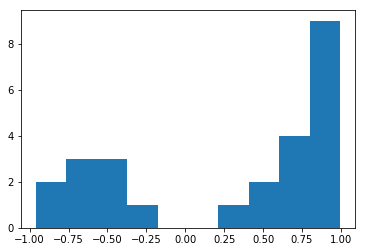

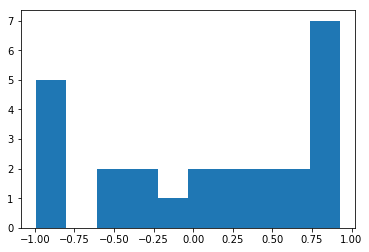

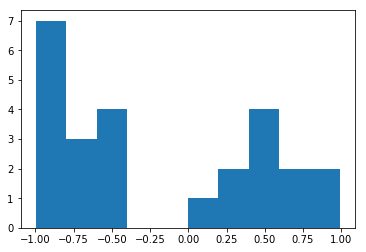

[ 0.2856778   0.10741055 -0.1777814 ]
0.284782171249
0.28839302063
0.283581018448
0.301647901535
0.282853841782
0.314210176468
0.28651714325
0.296354055405
0.286559104919
Training epoch 100
0.300657987595
Iter: 100
D loss: 6.654e-05
G_loss: -0.0001412
()
0.290137052536
0.286042928696
0.283398866653
0.286411046982
0.291759967804
0.293632984161
0.285449981689
0.315212965012
0.297602176666
Training epoch 200
0.286818027496
Iter: 200
D loss: 7.696e-05
G_loss: -0.000196
()
0.302866220474
0.294056892395
0.3400349617
0.298699140549
0.301740884781


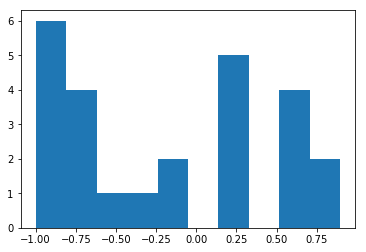

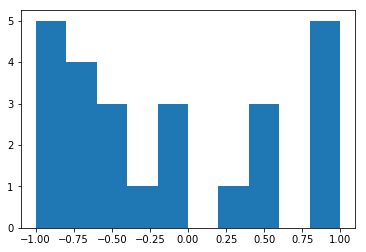

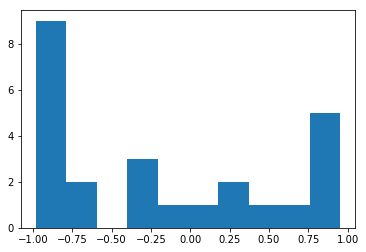

[-0.15889318 -0.13002109 -0.16221523]
0.299654960632
0.288120031357
0.314414978027
0.337557077408
Training epoch 300
0.284040927887
Iter: 300
D loss: 7.548e-05
G_loss: -0.0002568
()
0.323647022247
0.301469087601
0.307020187378
0.287172794342
0.295553922653
0.286983013153
0.312003850937
0.307664871216
0.285856962204
Training epoch 400
0.290026903152
Iter: 400
D loss: 7.592e-05
G_loss: -0.0002427
()
0.298980951309
0.288889169693
0.288858890533
0.305333137512
0.288702011108
0.29191493988
0.31379699707
0.305685997009
0.30147600174
Training epoch 500
0.295549869537
Iter: 500
D loss: 8.148e-05
G_loss: -0.0001485
()


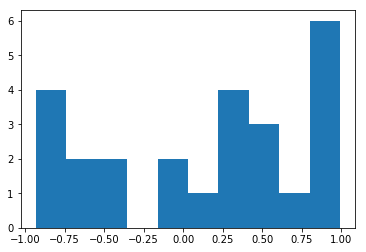

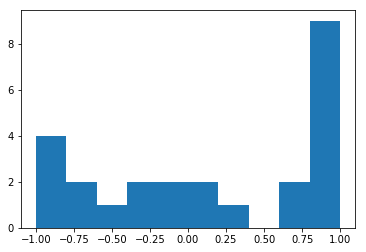

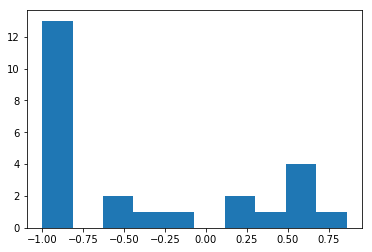

[ 0.15136927  0.14420029 -0.38917807]
0.286300897598
0.312497854233
0.335114002228
0.315465927124
0.285953998566
0.284646987915
0.286191940308
0.358462095261
0.360476016998
Training epoch 600
0.311642885208
Iter: 600
D loss: 8.625e-05
G_loss: -0.0001935
()
0.285852909088
0.28288602829
0.28574514389
0.284204006195
0.283074855804
0.279620885849
0.282127857208
0.282039880753
0.285270929337
Training epoch 700
0.313950061798
Iter: 700
D loss: 9.154e-05
G_loss: -0.0001457
()
0.294661998749
0.287420988083
0.288744926453
0.287420988083
0.336041927338


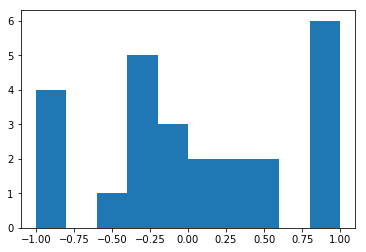

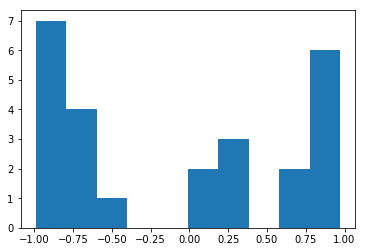

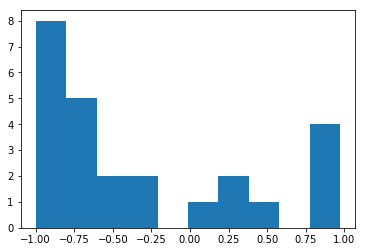

[ 0.06881121 -0.05645895 -0.30556085]
0.284189939499
0.300831079483
0.285387039185
0.305875062943
Training epoch 800
0.311227798462
Iter: 800
D loss: 8.045e-05
G_loss: -0.0001872
()
0.30025100708
0.288636922836
0.282248020172
0.338979959488
0.285291910172
0.282516002655
0.283315896988
0.282033920288
0.282892942429
Training epoch 900
0.282917976379
Iter: 900
D loss: 8.825e-05
G_loss: -0.0001587
()
0.286384105682
0.332412004471
0.284687042236
0.288271903992
0.28190279007
0.284896850586
0.297754049301
0.283759117126
0.340944766998
Training epoch 1000
0.313484191895
Iter: 1000
D loss: 7.067e-05
G_loss: -0.0001869
()


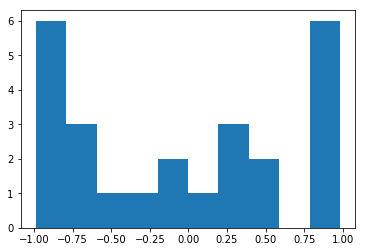

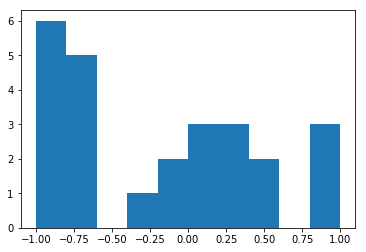

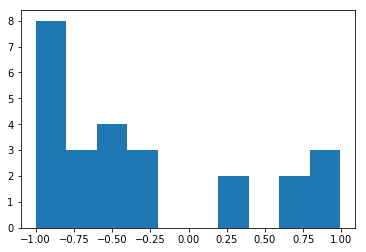

[-0.06649691 -0.20988416 -0.31480818]
0.289089918137
0.286616802216
0.303888082504
0.287212133408
0.285778999329
0.288537025452
0.288445949554
0.284278154373
0.309906959534
Training epoch 1100
0.285964012146
Iter: 1100
D loss: 7.544e-05
G_loss: -0.000218
()
0.285541057587
0.284801959991
0.287930965424
0.285963058472
0.286853075027
0.289657115936
0.319149971008
0.283740997314
0.284449100494
Training epoch 1200
0.287388086319
Iter: 1200
D loss: 8.723e-05
G_loss: -0.0001695
()
0.287635803223
0.31366109848
0.285861968994
0.286128997803
0.302276134491


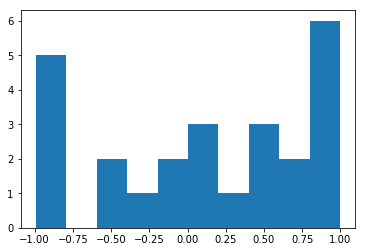

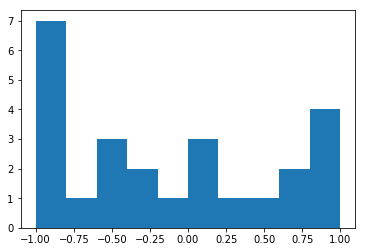

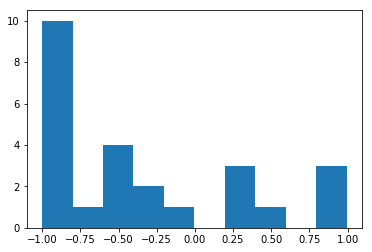

[ 0.10640536 -0.13009663 -0.34930208]
0.320796012878
0.306775093079
0.320800065994
0.291460037231
Training epoch 1300
0.283767223358
Iter: 1300
D loss: 8.273e-05
G_loss: -0.0001884
()
0.31464600563
0.314059019089
0.284749031067
0.281881093979
0.298804044724
0.283610105515
0.282923936844
0.280188083649
0.283993005753
Training epoch 1400
0.295140981674
Iter: 1400
D loss: 7.352e-05
G_loss: -0.000269
()
0.294318914413
0.288077116013
0.2858710289
0.309775114059


KeyboardInterrupt: 

In [39]:
import time 

with tf.device('/gpu:0'):

    G_pred = generator(z, is_training=False)
    G_sample = generator(z, is_training=True)

    D_real = discriminator(label_placeholder)
    D_fake = discriminator(G_sample)

    # D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
    # G_loss = -tf.reduce_mean(tf.log(D_fake))

    # Alternative losses:
    # -------------------

    #D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=ones_like))
    #D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=zeros_like))
    #D_loss = D_loss_real + D_loss_fake
    #G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=ones_like))

    #D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
    #D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
    #D_loss = D_loss_real + D_loss_fake
    #G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

    #WGAN:
    D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    G_loss = -tf.reduce_mean(D_fake)
    clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]

    #D_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=theta_D)
    #G_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G)

    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

train_dataset = [features[0] for i in range(0,S)]
#train_dataset = []
#for i in range(0,16):
#    train_dataset += features[:16]
n_train = len(train_dataset)
preds = []

d_losses = []
g_losses = []

for it in range(100000):
    a = time.time()
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D],
                feed_dict=feed_dict)
            
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    if it % 10 == 0:
        print(time.time()-a)

        
    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    if it % 250 == 0:
        samples = np.zeros((25,3))
        for i in range(0, 25):
            feed_dict = construct_feed_dict(train_dataset, start, stop, False)
            samples[i] = sess.run(G_sample, feed_dict=feed_dict)[0]
        plt.hist(samples[:,0], bins=10)
        plt.show()
        plt.hist(samples[:,1], bins=10)
        plt.show()
        plt.hist(samples[:,2], bins=10)
        plt.show()
        print(np.mean(samples, axis=0))
        #print(samples[:10])
        #plt.hist(samples, bins=50)
        #plt.show()
    

In [ ]:

[ 0.9370852 , -0.2220445 ,  0.   

In [43]:
train_dataset[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.        ,
         0.        ],
       [-0.97974276,  0.46090066,  0.58913924, -0.97974276,  0.97948206,
         0.        ],
       [ 0.0092509 ,  0.        ,  0.        ,  0.0092509 , -0.87576691,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

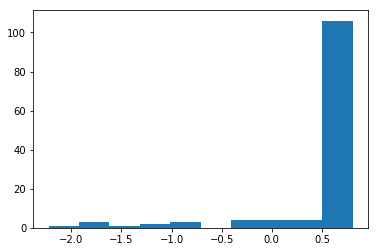

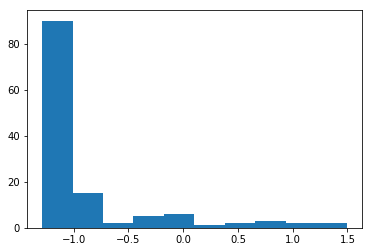

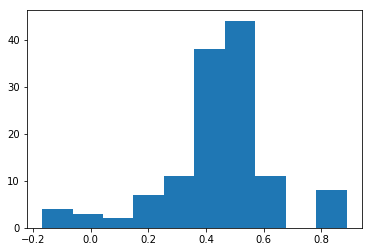

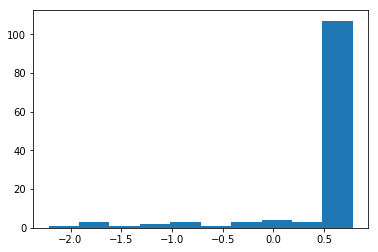

[  4.46803689e-01  -8.61598611e-01   4.45582092e-01   4.48124558e-01
   4.36727889e-02  -4.82748932e-04]


In [71]:
feed_dict = construct_feed_dict(train_dataset, start, stop, False)
inds = range(0,128*4,4)
samples = sess.run(G_sample, feed_dict=feed_dict)
samples = samples[inds]
plt.hist(samples[:,0], bins=10)
plt.show()
plt.hist(samples[:,1], bins=10)
plt.show()
plt.hist(samples[:,2], bins=10)
plt.show()
plt.hist(samples[:,3], bins=10)
plt.show()
print(np.mean(samples, axis=0))
#print(samples[:10])
#plt.hist(samples, bins=50)
#plt.show()

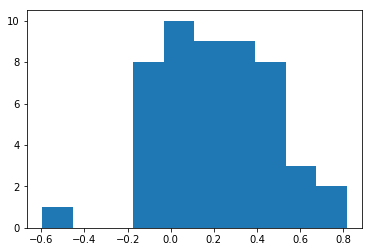

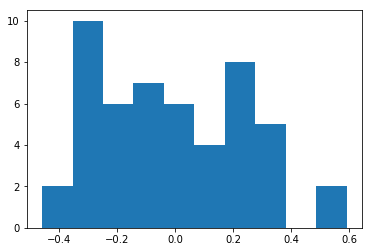

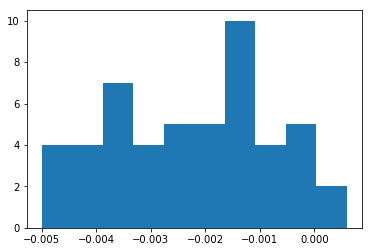

[  2.07347427e-01  -1.05754736e-02  -2.22802757e-03   2.06277720e-01
  -3.84236209e-01   2.61375877e-04]


In [18]:
samples = np.zeros((50,6))
for i in range(0, 50):
    feed_dict = construct_feed_dict(train_dataset, start, stop, False)
    samples[i] = sess.run(G_sample, feed_dict=feed_dict)[0]
plt.hist(samples[:,0], bins=10)
plt.show()
plt.hist(samples[:,1], bins=10)
plt.show()
plt.hist(samples[:,2], bins=10)
plt.show()
print(np.mean(samples, axis=0))
#print(samples[:10])
#plt.hist(samples, bins=50)
#plt.show()

In [68]:
samples

array([[  6.84835672e-01,  -1.08573687e+00,   4.22323346e-01,
          6.82211578e-01,  -4.60422635e-02,  -3.83595703e-04],
       [ -1.16148663e+00,   4.57557321e-01,   7.74113953e-01,
         -1.16413200e+00,   1.35043240e+00,  -1.09859398e-02],
       [  2.50741839e-02,  -8.41215253e-03,   3.28766704e-02,
          2.97103524e-02,  -9.41532671e-01,  -1.17874378e-02],
       [  7.66777635e-01,  -9.76679802e-01,   2.04086065e-01,
          7.34566987e-01,  -3.41211140e-01,  -1.09715213e-03],
       [  6.33780718e-01,  -1.08032167e+00,   4.62026298e-01,
          6.40313804e-01,   8.02031755e-02,   2.44973227e-04],
       [ -1.64962935e+00,   8.39063168e-01,   9.42281187e-01,
         -1.66608095e+00,   1.82514763e+00,  -1.20780291e-02],
       [  5.93720675e-02,  -5.27790189e-03,  -9.82954502e-02,
          4.30758595e-02,  -8.59469235e-01,   3.24005191e-03],
       [  6.26198530e-01,  -6.41943932e-01,   5.95412850e-02,
          6.21082127e-01,  -5.85359752e-01,  -9.47615132e-04],


In [ ]:
  [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.      

In [7]:
np.where(feed_dict[dihed_indices][0] != 0)

NameError: name 'np' is not defined

In [8]:
feed_dict[label_placeholder]

NameError: name 'feed_dict' is not defined

In [ ]:
feed_dict[non_zero_inds]

In [113]:
features[0][1][1].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.61143659, -0.99900387,  0.48252666,  0.61143659,  0.        ,
         0.        ],
       [-0.97974276,  0.46090066,  0.58913924, -0.97974276,  0.97948206,
         0.        ],
       [ 0.0092509 ,  0.        ,  0.        ,  0.0092509 , -0.87576691,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

In [ ]:
sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],

In [ ]:
plt.hist(sess.run(G_sample, feed_dict=feed_dict))

In [ ]:
batch_sched

In [ ]:
for it in range(20001):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict=feed_dict)
        plt.hist(samples, bins=50)
        plt.show()


In [ ]:
preds = []
for k in range(0,100):
    feed_dict = construct_feed_dict(train_dataset, 0, 1)
    samples = sess.run(G_sample, feed_dict=feed_dict)[2]
    preds.append(samples)

In [ ]:
plt.hist(np.concatenate(preds))

In [ ]:
preds[4]

In [ ]:
train_dataset[0][1][1].toarray()

In [ ]:
res = gan.predict()

In [ ]:
res

In [ ]:
plt.hist(res, bins=50)
plt.show()

In [ ]:
features[0][1][1].toarray()

In [ ]:
features[0][1][1].toarray()

In [ ]:
preds = []
for i in range(0,100):
    preds.append(gan.predict(features)[0][2])

In [ ]:
np.mean(preds)

In [ ]:
features[0][2].atom_features